**Federal University of Pernambuco - Center of Informatics (UFPE-CIn)**  
**Master's Degree Program in Computer Sciences**  
**Discipline:** Neural Networks  
**Professor:** Aluízio Fausto Ribeiro Araújo  
**Scholars:** Constantino Cândido Maranhão Mariz Neto, Eduardo Henrique Ximenes de Melo e Menezes, Gabriel Oliveira Gonçalves

# Fundamentals

## Necessary libraries

In [ ]:
pip install aeon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 MB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install sklearn-som

In [ ]:
!pip install scikit-posthocs

In [ ]:
from aeon.datasets import load_classification

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn_som.som import SOM
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.metrics import silhouette_score as silhouette
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape

from scipy import stats
import scikit_posthocs as sp

## Adjusting SKLearn-SOM

In [ ]:
class SOMCosine(SOM):
  def __init__(self, m=10, n=10, dim=2, lr=0.5, sigma=None):
    if sigma is None:
      super().__init__(m, n, dim, lr)
    else:
      super().__init__(m, n, dim, lr, sigma)
    self.weights = normalize(np.random.rand(m * n, dim), axis=1)

  def _find_bmu(self, x):
    x = x.reshape(1, -1)
    dists = cosine_distances(self.weights, x)
    return np.argmin(dists)

  def fit(self, X, epochs=100, shuffle=True):
    X = normalize(X, axis=1)
    super().fit(X, epochs, shuffle)

# Model implementation  
The model has three main pipelines, one for splitting data in X and y as well as train and test, another one for training SOM based on train X set, and yet another one for specialized forecasting. The first pipeline splits the series in time windows considering a number of timesteps for prediction (X) and the prediction horizon (y), and afterwards it will divide them in train and test; the SOM pipeline will train the map with train X data and register to which label each window from train X set belongs; lastly, the prediction pipeline will identify to which label each window from the test X set belongs, so a specialized LSTM recurrent neural network can be trained with every window from train X with the same label for the test window.

In [ ]:
# Extracting datasets to be used in the project

dataset_dict = {}
selected_datasets = ["AbnormalHeartbeat", "Adiac", "ECG5000", "InsectWingbeatSound", "FaceAll"]

for dataset in selected_datasets:
    X, y = load_classification(dataset)
    dataset_dict[dataset] = {'X': X, 'y': y}
    print(f"{dataset}: Shape of X = {X.shape}, Shape of y = {y.shape}")

AbnormalHeartbeat: Shape of X = (409, 1, 18530), Shape of y = (409,)
Adiac: Shape of X = (781, 1, 176), Shape of y = (781,)
ECG5000: Shape of X = (5000, 1, 140), Shape of y = (5000,)
InsectWingbeatSound: Shape of X = (2200, 1, 256), Shape of y = (2200,)
FaceAll: Shape of X = (2250, 1, 131), Shape of y = (2250,)


## Pipelines

In [ ]:
# General function for splitting a series in time windows with a given size and step between windows

def create_window(data, window_size, step):
  sequences = []
  for start in range(0, data.shape[0] - window_size + 1, step):
    sequence = data[start:start+window_size]
    sequences.append(sequence)
  return np.array(sequences)


# Splitting subseries in past timesteps and prediction horizons
# By default, the horizon will be defined as 1 (next-step forecasting)

def split_Xy(windows, horizon=1):
  X = []
  y = []
  for window in windows:
    X.append(window[:-horizon])
    y.append(window[-horizon:])
  return np.array(X), np.array(y)


# Splitting windows in X_train, X_test, y_train and y_test
# By default, train fracion will be 0.8, or 80%

def split_train_test(windows, horizon=1, frac_train=0.8):
  # Splitting X and y sets from windows
  X, y = split_Xy(windows, horizon)

  # Splitting X and y in train and test splits
  X_train = X[:int(frac_train*len(X))]
  X_test = X[int(frac_train*len(X)):]
  y_train = y[:int(frac_train*len(y))]
  y_test = y[int(frac_train*len(y)):]
  return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


# Condensed splitting pipeline

def pipeline_splitting(series, window_size, n_steps, horizon=1, frac_train=0.8):
  windows = create_window(series, window_size, n_steps)
  X_train, X_test, y_train, y_test = split_train_test(windows, horizon, frac_train)
  return X_train, X_test, y_train, y_test

In [ ]:
# Defining the SOM training pipeline
# By default, it will feature a 5x5 grid with a learning rate of 0.5, and 100 epochs of training

def pipeline_SOM(X_train, m=5, n=5, lr=0.5, epochs=100):
  model = SOMCosine(m=m, n=m, lr=lr, dim=X_train.shape[-1])
  model.fit(X_train, epochs=epochs)

  labels_SOM = []
  for window in X_train:
    labels_SOM.append(model._find_bmu(window.transpose()))

  return model, labels_SOM


# Defining a standard SOM pipeline for comparing euclidean and cosine distances

def pipeline_SOM_vanilla(X_train, m=5, n=5, lr=0.5, epochs=100):
  model = SOM(m=m, n=m, lr=lr, dim=X_train.shape[-1])
  model.fit(X_train, epochs=epochs)

  labels_SOM = []
  for window in X_train:
    labels_SOM.append(model._find_bmu(window.transpose()))

  return model, labels_SOM

In [ ]:
# Development of the LSTM pipeline

def LSTM(X_train, y_train, window_size, n_features=1, horizon=1, epochs=50):
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=(window_size, n_features)))
  model.add(keras.layers.LSTM(50, activation='relu'))
  model.add(keras.layers.Dense(horizon))
  model.compile(optimizer='adam', loss='mse')
  model.fit(X_train, y_train, epochs=epochs, verbose=1)
  return model

def pipeline_LSTM(X_train, y_train, X_test, model_SOM, labels_SOM, window_size, n_features=1, horizon=1, epochs=50):
  predicts_test = []
  for window in X_test: # Starting the pipeline for each test window
    label_test = model_SOM._find_bmu(window) # Predicting the label for the test window
    windows_train = []
    for index in range(len(labels_SOM)): # Iterating through the train labels
      if labels_SOM[index] == label_test:
        windows_train.append(X_treino[index]) # Assembling the specialized train set
    specialized_LSTM = LSTM(X_train=X_train, y_train=y_train, window_size=window_size,
                            n_features=n_features, horizon=horizon, epochs=epochs)
    prediction_LSTM = specialized_LSTM.predict(window.reshape(1,-1))
    predicts_test.append(prediction_LSTM) # Appending the specialized LSTM prediction of the test window
    keras.backend.clear_session() # Clearing keras backend to spare memory
    del specialized_LSTM # Deleting the model variable, since it will no longer be used
  return predicts_test

## Metrics

In [ ]:
# Compiling the metrics

def metrics(y_true, y_pred):
  metric_rmse = mse(y_true, y_pred, squared=False) # Raiz de erro quadrático médio
  metric_mape = mape(y_true, y_pred) # Erro percentual absoluto médio
  return metric_rmse, metric_mape

def plot_graph(y_true, y_pred, model_title):
  fig, ax = plt.subplots(figsize=(10,5))
  ax.set_title(f'Best predictions of model {titulo_modelo} vs Test series')
  ax.plot(y_true, color='blue', label='Actual series')
  ax.plot(y_pred, color='orange', label='Prediction')
  ax.legend()
  return fig

## Compilação

In [ ]:
# Complete pipeline of the model

def pipeline_TS_SOM_LSTM(series, n_steps=1, horizon=1, frac_train=0.8, epochs_SOM=100, max_iter=500, n_features=1, repeats_LSTM=10, epochs_LSTM=50):
  best_window = 5 # Initializing the best window size as a minimum
  best_m = 3 # Initializing the best m SOM parameter as a minimum
  best_n = 1 # Initializing the best m SOM parameter as a minimum
  best_lr = 0.5 # Initializing the best SOM learning rate as a minimum
  best_SOM = [] # Initializing the best SOM parameter as an empty object
  best_labels_SOM = [] # Initializing the best SOM labels parameter as an empty list
  best_sil = -1 # Initializing the best SOM silhouette as a minimum
  stable_optimization = 0 # Value for escaping gridsearch in case of many iterations without new optimizations

  # Otimização do SOM com os pipelines de divisão e treino do mapa auto-organizável
  for window_size in range(5, max(21, int(len(series)*0.05)+1)): # Optimizing window size between 5 and the greater value between 20 and 5% of the size of the series
    for n_SOM in [1, 3, 5, 7, 10, 15]: # Optimizing n SOM parameter among values 1, 3, 5, 7, 10 e 15
      for m_SOM in [3, 5, 7, 10, 15]: # Optimizing m SOM parameter among values 3, 5, 7, 10 e 15
        for learning_rate in [0.5, 0.1, 0.05]: # Optimizing SOM learning rate among values 0.5, 0.1 e 0.05
          print(f'Testing the following settings: Window size: {window_size} / m dimension: {m_SOM} / n dimension: {n_SOM} / Learning rate: {learning_rate}')
          silhouettes = []
          for i in range(5): # Running SOM 5 times to register average silhouette score
            X_train, X_test, y_train, y_test = pipeline_splitting(series=series, window_size=window_size, n_steps=n_steps, horizon=horizon, frac_train=frac_train)
            model_SOM, labels_SOM = pipeline_SOM(X_treino, m=m_SOM, n=n_SOM, taxa_aprendizagem=taxa_aprendizagem, epocas=epocas_SOM)
            silhouettes.append(silhouette(X_train, model_SOM.predict(X_train), metric='cosine'))
          silhouette = np.array(silhouettes).mean()
          if silhouette > best_sil: # Updating parameters after a new optimization has been found
            print(f'Model optimized! Silhouette: {silhouette}\n')
            best_sil = silhouette
            best_window = window_size
            best_m = m_SOM
            best_n = n_SOM
            best_lr = learning_rate
            best_SOM = model_SOM
            best_labels_SOM = labels_SOM
            stable_optimization = 0 # Escape value is reverted to zero after an optimization has been found
          else:
            stable_optimization += 1 # Incrementing escape value
          if stable_optimization > max_iter: # Escaping learning rate loop
            break
        if stable_optimization > max_iter: # Escaping m SOM parameter loop
          break
      if stable_optimization > max_iter: # Escaping n SOM parameter loop
        break
    if stable_optimization > max_iter: # Escaping window size loop
      break

  # Summarizing best settings
  print(f'Average silhouette score of the best setting: {best_sil}')
  print(f'Window size: {best_window} / m parameter: {best_m} / n parameter: {best_n} / Learning rate: {best_lr}')

  # Splitting series in train and test sets using best_window
  X_treino, X_teste, y_treino, y_teste = pipeline_divisao(series=series, window_size=best_window, n_steps=n_steps, horizon=horizon, frac_train=frac_train)

  # Initializing a list to compile the results of each model in a DataFrame
  final_results = []

  # Starting a loop with multiple iterations for enabling statistical analysis in the future
  for i in range (repeats_LSTM):
    # Starting LSTM and evaluation pipelines
    predictions = pipeline_LSTM(X_train=X_train, y_train=y_train, X_test=X_test, model_SOM=best_SOM, labels_SOM=best_labels_SOM,
                                window_size=best_window-1, n_features=n_features, horizon=horizon, epochs=epochs_LSTM)
    predictions = np.array(predictions).flatten()
    metrics_predictions = metrics(y_test, predictions)

    # Running standard SOM with LSTM for comparison 
    model_SOM_vanilla, labels_SOM_vanilla = pipeline_SOM_vanilla(X_train, m=best_m, n=best_n, lr=best_lr, epochs=epochs_SOM)
    predictions_vanilla = pipeline_LSTM(X_train=X_train, y_train=y_train, X_test=X_test, model_SOM=model_SOM_vanilla, labels_SOM=labels_SOM_vanilla,
                                        window_size=best_size-1, n_features=n_features, horizon=horizon, epochs=epochs_LSTM)
    predictions_vanilla = np.array(predictions_vanilla).flatten()
    metrics_predictions_vanilla = metrics(y_test, predictions_vanilla)

    # Running a generalist LSTM without SOM for comparison
    LSTM_raw = LSTM(X_train=X_train, y_train=y_train, window_size=best_window-1, n_features=n_features, horizon=horizon, epochs=epochs_LSTM)
    predictions_LSTM_raw = LSTM_raw.predict(X_test)
    metrics_predictions_LSTM_raw = metrics(y_test, predictions_LSTM_raw)
    keras.backend.clear_session() # Clearing keras backend to spare memory
    del LSTM_raw # Deleting the model variable, since it will no longer be used

    # Gathering predictions and metrics in a dictionary
    final_results.append({'RMSE_SOMcos_LSTM':metrics_predictions[0],
                          'MAPE_SOMcos_LSTM':metrics_predictions[1],
                          'Predictions_SOMcos_LSTM':metrics_predictions,
                          'RMSE_SOMeuc_LSTM':metrics_predictions_vanilla[0],
                          'MAPE_SOMeuc_LSTM':metrics_predictions_vanilla[1],
                          'Predictions_SOMeuc_LSTM':predictions_vanilla,
                          'RMSE_LSTM_raw':metrics_predictions_LSTM_raw[0],
                          'MAPE_LSTM_raw':metrics_predictions_LSTM_raw[1],
                          'Predictions_LSTM_raw':predictions_LSTM_raw})

  # Deleting the models variables which will no longer be used
  del modelo_SOM
  del modelo_SOM_vanilla

  # Compiling the metrics in a DataFrame
  final_results = pd.DataFrame(final_results)

  # Plotting graphs of the best predictions for each model
  preds_SOMcos = np.array(final_results.sort_values(['RMSE_SOMcos_LSTM', 'MAPE_SOMcos_LSTM']).Predictions_SOMcos_LSTM.head(1).values[0])
  preds_SOMeuc = np.array(final_results.sort_values(['RMSE_SOMeuc_LSTM', 'MAPE_SOMeuc_LSTM']).Predictions_SOMeuc_LSTM.head(1).values[0])
  preds_LSTM = np.array(final_results.sort_values(['RMSE_LSTM_raw', 'MAPE_LSTM_raw']).Predictions_LSTM_raw.head(1).values[0])
  graph_pred = plot_graph(y_teste, preds_SOMcos, 'SOM cosine + LSTM')
  graph_pred_vanilla = plot_graph(y_teste, preds_SOMeuc, 'SOM euclidean + LSTM')
  graph_pred_LSTM_raw = plot_graph(y_teste, preds_LSTM, 'LSTM raw')
  return final_results, graph_pred.show(), graph_pred_vanilla.show(), graph_pred_LSTM_raw.show()

# Running the model

## Dataset Adiac

In [ ]:
# Identifying how many classes the dataset has and selecting two of them randomly
np.random.seed(42)
classes_adiac = np.unique(dataset_dict['Adiac']['y'])
classes_adiac = np.random.choice(classes_adiac, 2).astype(int)

# Selecting two samples, each belonging to a different class of the dataset
samples_adiac = []
for class_adiac in classes_adiac:
  candidates = [index for index in range(len(dataset_dict['Adiac']['y'])) if int(dataset_dict['Adiac']['y'][index]) == class_adiac]
  samples_adiac.append(np.random.choice(candidates, 1))
print(samples_adiac)

[array([425]), array([261])]


Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Otimização encontrada! Silhueta: 0.2927381821761999

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Otimização encontrada! Silhueta: 0.5142867744533437

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem: 

1/1 [==============================] - 0s 321ms/step
Epoch 1/150
4/4 [==============================] - 3s 17ms/step - loss: 1.0772
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 0.9426
Epoch 3/150
4/4 [==============================] - 0s 13ms/step - loss: 0.8258
Epoch 4/150
4/4 [==============================] - 0s 13ms/step - loss: 0.7153
Epoch 5/150
4/4 [==============================] - 0s 12ms/step - loss: 0.5999
Epoch 6/150
4/4 [==============================] - 0s 14ms/step - loss: 0.4841
Epoch 7/150
4/4 [==============================] - 0s 15ms/step - loss: 0.3623
Epoch 8/150
4/4 [==============================] - 0s 13ms/step - loss: 0.2341
Epoch 9/150
4/4 [==============================] - 0s 13ms/step - loss: 0.1713
Epoch 10/150
4/4 [==============================] - 0s 13ms/step - loss: 0.1810
Epoch 11/150
4/4 [==============================] - 0s 15ms/step - loss: 0.1370
Epoch 12/150
4/4 [==============================] - 0s 18ms/step - loss: 0.1

Streaming output truncated to the last 5000 lines.
Epoch 60/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0032
Epoch 61/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0032
Epoch 62/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0030
Epoch 63/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0034
Epoch 64/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0033
Epoch 65/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0032
Epoch 66/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 67/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0029
Epoch 68/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 69/150
4/4 [==============================] - 0s 13ms/step - loss: 0.0028
Epoch 70/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0028
Epoch 71/150
4/4 [==============================] - 0s 14ms/step - lo

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0           0.05813          0.114904   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [-0.81190073, -0.72097445, -0.652311, -0.56908...          0.059567   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          0.085055  [-0.8185832, -0.7327433, -0.6867878, -0.572210...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0        0.049556        0.131544   

                                 Previsoes_LSTM_puro  
0  [[-0.75754154], [-0.70320153], [-0.6357429], [...

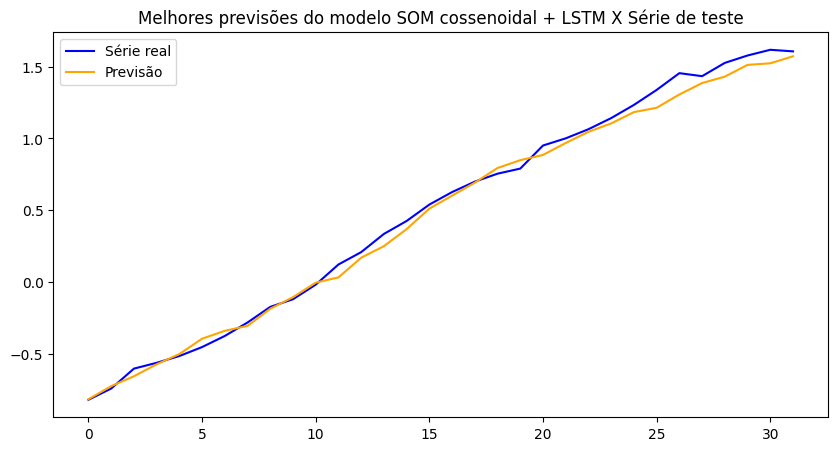

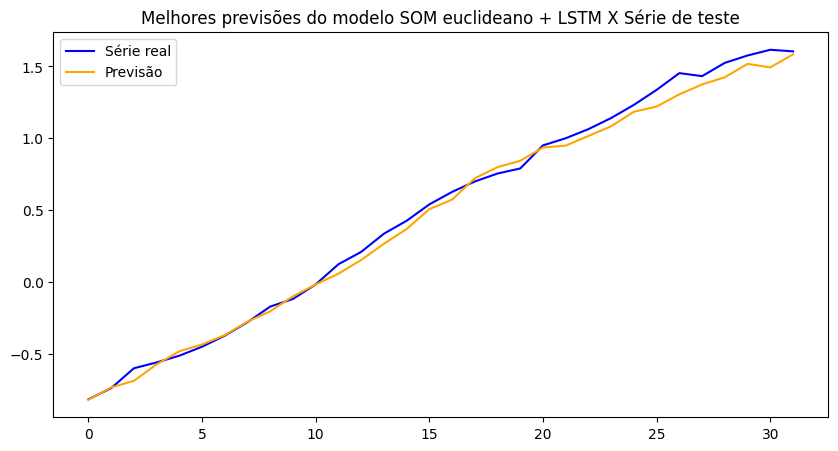

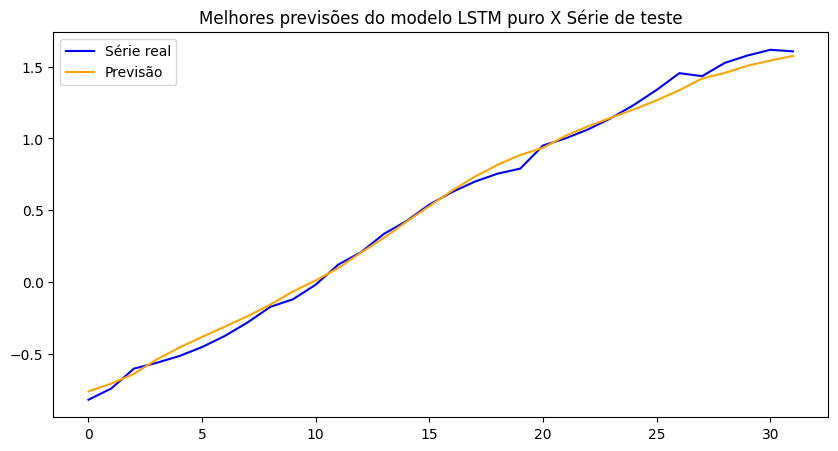

In [ ]:
adiac_1 = dataset_dict['Adiac']['X'][samples_adiac[0]].copy().flatten()
adiac_1_results, adiac_1_graph1, adiac_1_graph2, adiac_1_graph3 = pipeline_TS_SOM_LSTM(adiac_1, epochs_SOM=200, max_iter=270,
                                                                                       repeats_LSTM=1, epochs_LSTM=150)
adiac_1_results

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Otimização encontrada! Silhueta: 0.4460087119143992

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Otimização encontrada! Silhueta: 0.497406803511268

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem: 0

1/1 [==============================] - 0s 228ms/step
Epoch 1/150
4/4 [==============================] - 3s 14ms/step - loss: 1.0104
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 0.8663
Epoch 3/150
4/4 [==============================] - 0s 12ms/step - loss: 0.7465
Epoch 4/150
4/4 [==============================] - 0s 13ms/step - loss: 0.6242
Epoch 5/150
4/4 [==============================] - 0s 12ms/step - loss: 0.5196
Epoch 6/150
4/4 [==============================] - 0s 13ms/step - loss: 0.4166
Epoch 7/150
4/4 [==============================] - 0s 19ms/step - loss: 0.3435
Epoch 8/150
4/4 [==============================] - 0s 18ms/step - loss: 0.2537
Epoch 9/150
4/4 [==============================] - 0s 14ms/step - loss: 0.1913
Epoch 10/150
4/4 [==============================] - 0s 13ms/step - loss: 0.1266
Epoch 11/150
4/4 [==============================] - 0s 14ms/step - loss: 0.1132
Epoch 12/150
4/4 [==============================] - 0s 12ms/step - loss: 0.1

Streaming output truncated to the last 5000 lines.
Epoch 60/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 61/150
4/4 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 62/150
4/4 [==============================] - 0s 12ms/step - loss: 9.8987e-04
Epoch 63/150
4/4 [==============================] - 0s 12ms/step - loss: 9.8813e-04
Epoch 64/150
4/4 [==============================] - 0s 12ms/step - loss: 9.0293e-04
Epoch 65/150
4/4 [==============================] - 0s 12ms/step - loss: 8.6073e-04
Epoch 66/150
4/4 [==============================] - 0s 14ms/step - loss: 9.0965e-04
Epoch 67/150
4/4 [==============================] - 0s 12ms/step - loss: 9.6415e-04
Epoch 68/150
4/4 [==============================] - 0s 12ms/step - loss: 8.9730e-04
Epoch 69/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0012
Epoch 70/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0010
Epoch 71/150
4/4 [=======================

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0          0.026905          0.044087   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [-0.86831325, -0.80625224, -0.7261037, -0.6854...          0.028808   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          0.077779  [-0.8633857, -0.78296196, -0.7234757, -0.65237...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0        0.026389        0.032196   

                                 Previsoes_LSTM_puro  
0  [[-0.83998144], [-0.77670985], [-0.7090083], [...

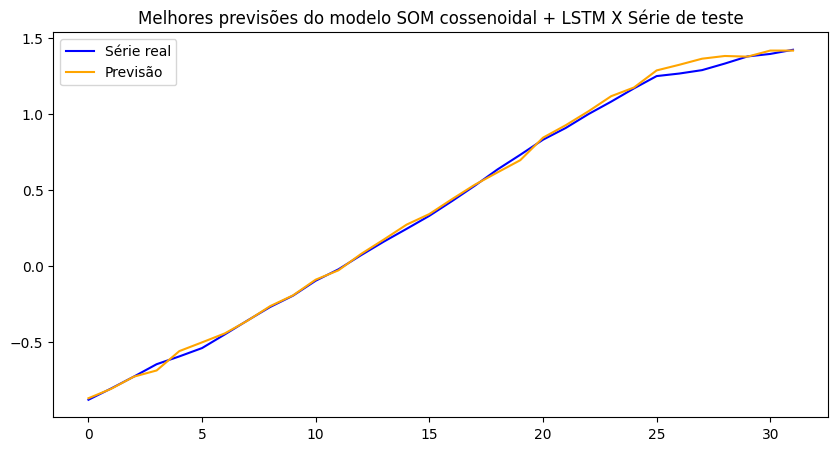

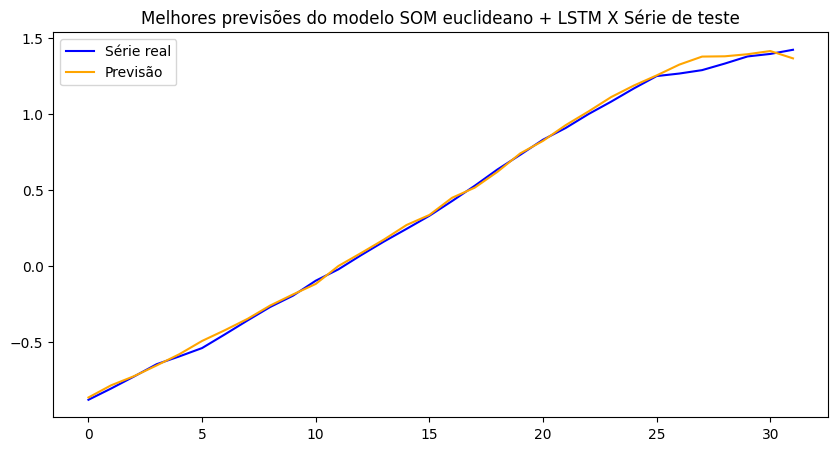

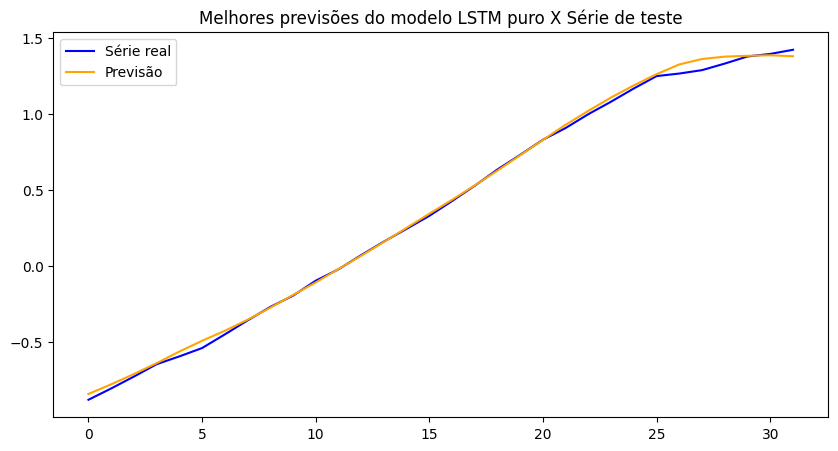

In [ ]:
adiac_2 = dataset_dict['Adiac']['X'][samples_adiac[1]].copy().flatten()
adiac_2_results, adiac_2_graph1, adiac_2_graph2, adiac_2_graph3 = pipeline_TS_SOM_LSTM(adiac_2, epochs_SOM=200, max_iter=270,
                                                                                       repeats_LSTM=1, epochs_LSTM=150)
adiac_2_results

## Dataset ECG5000

In [ ]:
# Identifying how many classes the dataset has and selecting two of them randomly
np.random.seed(42)
classes_ecg = np.unique(dataset_dict['ECG5000']['y'])
classes_ecg = np.random.choice(classes_ecg, 2).astype(int)

# Selecting two samples, each belonging to a different class of the dataset
samples_ecg = []
for class_ecg in classes_ecg:
  candidates = [index for index in range(len(dataset_dict['ECG5000']['y'])) if int(dataset_dict['ECG5000']['y'][index]) == class_ecg]
  samples_ecg.append(np.random.choice(candidates, 1))
print(samples_ecg)

[array([493]), array([3750])]


Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Otimização encontrada! Silhueta: 0.23315259606111355

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Otimização encontrada! Silhueta: 0.24298503492223206

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem

1/1 [==============================] - 0s 377ms/step
Epoch 1/150
4/4 [==============================] - 3s 14ms/step - loss: 0.3794
Epoch 2/150
4/4 [==============================] - 0s 11ms/step - loss: 0.3322
Epoch 3/150
4/4 [==============================] - 0s 10ms/step - loss: 0.2925
Epoch 4/150
4/4 [==============================] - 0s 14ms/step - loss: 0.2544
Epoch 5/150
4/4 [==============================] - 0s 11ms/step - loss: 0.2177
Epoch 6/150
4/4 [==============================] - 0s 12ms/step - loss: 0.1772
Epoch 7/150
4/4 [==============================] - 0s 14ms/step - loss: 0.1424
Epoch 8/150
4/4 [==============================] - 0s 13ms/step - loss: 0.1071
Epoch 9/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0840
Epoch 10/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0747
Epoch 11/150
4/4 [==============================] - 0s 13ms/step - loss: 0.0701
Epoch 12/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0

Streaming output truncated to the last 5000 lines.
Epoch 60/150
4/4 [==============================] - 0s 15ms/step - loss: 0.0094
Epoch 61/150
4/4 [==============================] - 0s 13ms/step - loss: 0.0091
Epoch 62/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0089
Epoch 63/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0089
Epoch 64/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0086
Epoch 65/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0085
Epoch 66/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0085
Epoch 67/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0083
Epoch 68/150
4/4 [==============================] - 0s 17ms/step - loss: 0.0082
Epoch 69/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0088
Epoch 70/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 71/150
4/4 [==============================] - 0s 14ms/step - lo

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0          1.293553          0.490988   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [0.8045271, 0.78154814, 0.66188616, 0.9160935,...          1.495371   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          0.552285  [0.7925075, 0.7952153, 0.8476045, 0.97976625, ...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0        0.624688        0.263195   

                                 Previsoes_LSTM_puro  
0  [[0.7952727], [0.83067113], [0.8400902], [0.92...

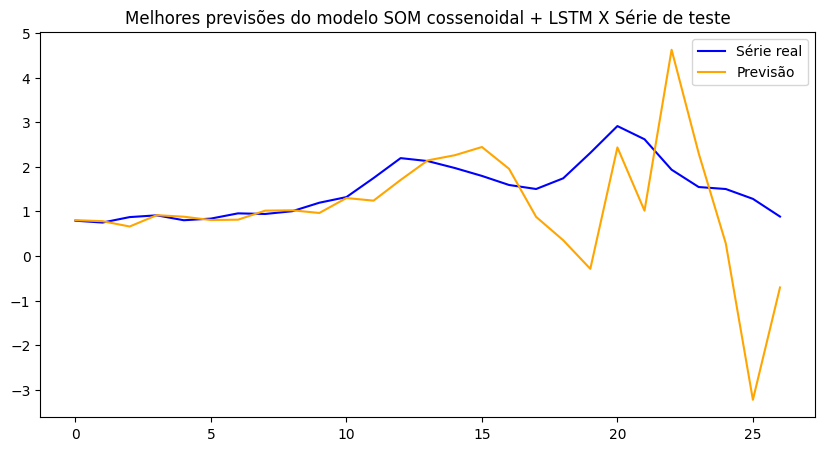

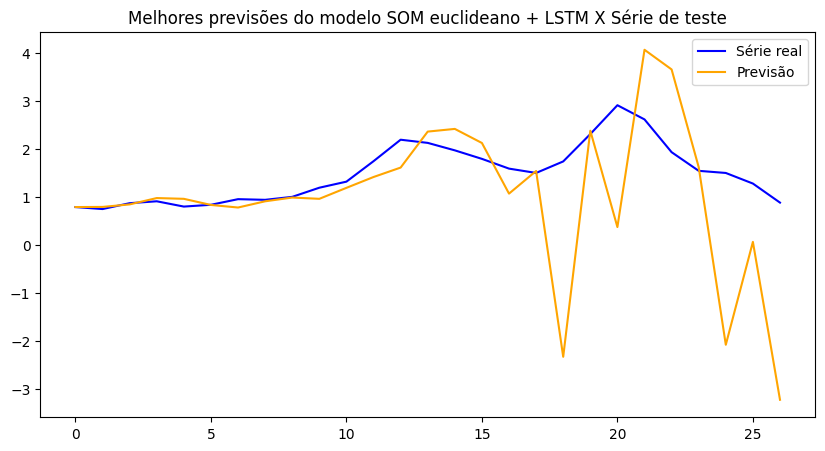

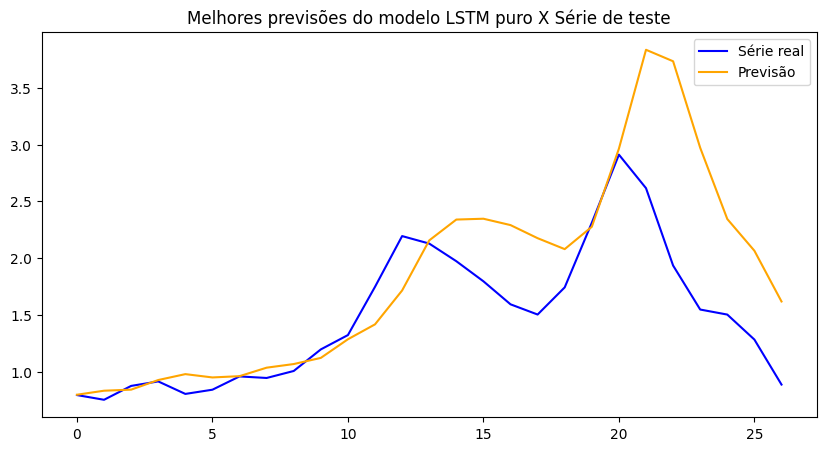

In [ ]:
ecg_1 = dataset_dict['ECG5000']['X'][samples_ecg[0]].copy().flatten()
ecg_1_results, ecg_1_graph1, ecg_1_graph2, ecg_1_graph3 = pipeline_TS_SOM_LSTM(ecg_1, epochs_SOM=200, max_iter=270,
                                                                               repeats_LSTM=1, epochs_LSTM=150)
ecg_1_results

Streaming output truncated to the last 5000 lines.
Epoch 60/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0519
Epoch 61/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0506
Epoch 62/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0509
Epoch 63/150
4/4 [==============================] - 0s 16ms/step - loss: 0.0501
Epoch 64/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0460
Epoch 65/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0478
Epoch 66/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0537
Epoch 67/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0448
Epoch 68/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0470
Epoch 69/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0429
Epoch 70/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0427
Epoch 71/150
4/4 [==============================] - 0s 10ms/step - loss: 0

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0          0.259944           1.55507   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [-0.070546776, -0.083393715, -0.1316678, -0.17...          0.242947   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          1.409024  [-0.06945466, -0.059340417, -0.13764021, -0.14...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0          0.2426        1.359543   

                                 Previsoes_LSTM_puro  
0  [[-0.07529251], [-0.069155335], [-0.142704], [...

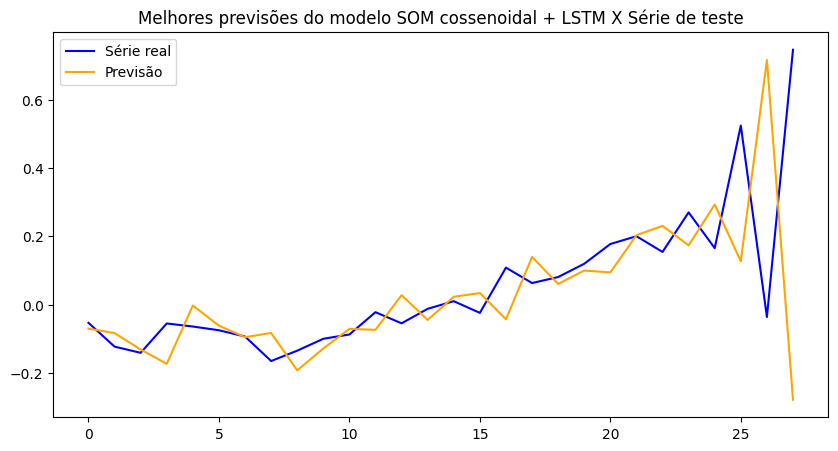

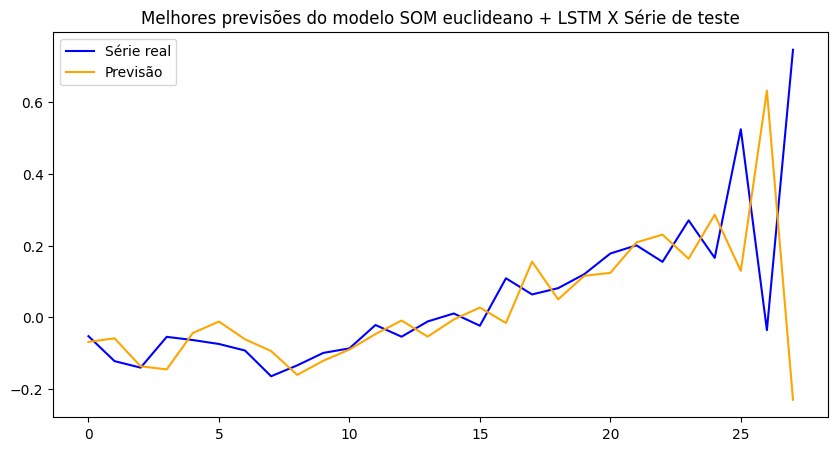

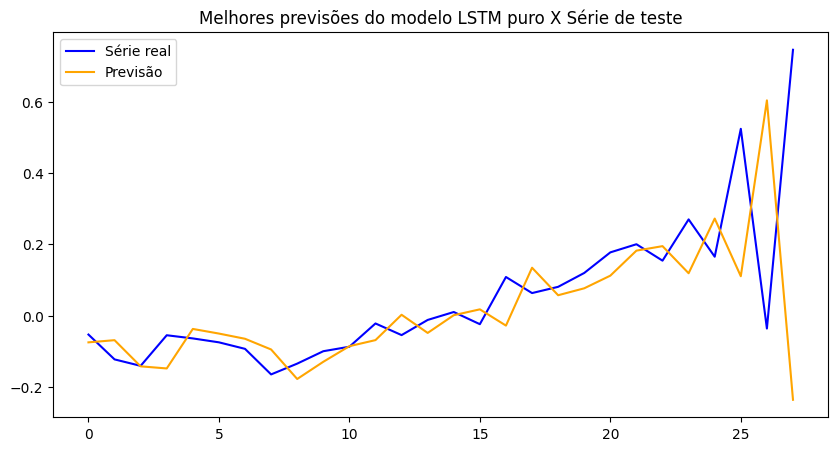

In [ ]:
ecg_2 = dataset_dict['ECG5000']['X'][samples_ecg[1]].copy().flatten()
ecg_2_results, ecg_2_graph1, ecg_2_graph2, ecg_2_graph3 = pipeline_TS_SOM_LSTM(ecg_2, epochs_SOM=200, max_iter=270,
                                                                               repeats_LSTM=1, epochs_LSTM=150)
ecg_2_results

## Dataset InsectWingbeatSound

In [ ]:
# Identifying how many classes the dataset has and selecting two of them randomly
np.random.seed(42)
classes_insect = np.unique(dataset_dict['InsectWingbeatSound']['y'])
classes_insect = np.random.choice(classes_insect, 2).astype(int)

# Selecting two samples, each belonging to a different class of the dataset
samples_insect = []
for class_insect in classes_insect:
  candidates = [index for index in range(len(dataset_dict['InsectWingbeatSound']['y'])) if int(dataset_dict['InsectWingbeatSound']['y'][index]) == class_insect]
  samples_insect.append(np.random.choice(candidates, 1))
print(samples_insect)

[array([974]), array([157])]


Streaming output truncated to the last 5000 lines.
Epoch 60/150
7/7 [==============================] - 0s 11ms/step - loss: 0.0524
Epoch 61/150
7/7 [==============================] - 0s 11ms/step - loss: 0.0514
Epoch 62/150
7/7 [==============================] - 0s 10ms/step - loss: 0.0530
Epoch 63/150
7/7 [==============================] - 0s 11ms/step - loss: 0.0529
Epoch 64/150
7/7 [==============================] - 0s 9ms/step - loss: 0.0481
Epoch 65/150
7/7 [==============================] - 0s 11ms/step - loss: 0.0473
Epoch 66/150
7/7 [==============================] - 0s 13ms/step - loss: 0.0476
Epoch 67/150
7/7 [==============================] - 0s 12ms/step - loss: 0.0465
Epoch 68/150
7/7 [==============================] - 0s 16ms/step - loss: 0.0440
Epoch 69/150
7/7 [==============================] - 0s 16ms/step - loss: 0.0437
Epoch 70/150
7/7 [==============================] - 0s 14ms/step - loss: 0.0460
Epoch 71/150
7/7 [==============================] - 0s 14ms/step - los

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0           0.10973          0.361039   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [-0.30610153, -0.44380423, -0.29492122, -0.343...          0.113461   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          0.488255  [-0.39894184, -0.27510095, -0.36354813, -0.375...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0        0.110992        0.285913   

                                 Previsoes_LSTM_puro  
0  [[-0.34410718], [-0.34418306], [-0.34433925], ...

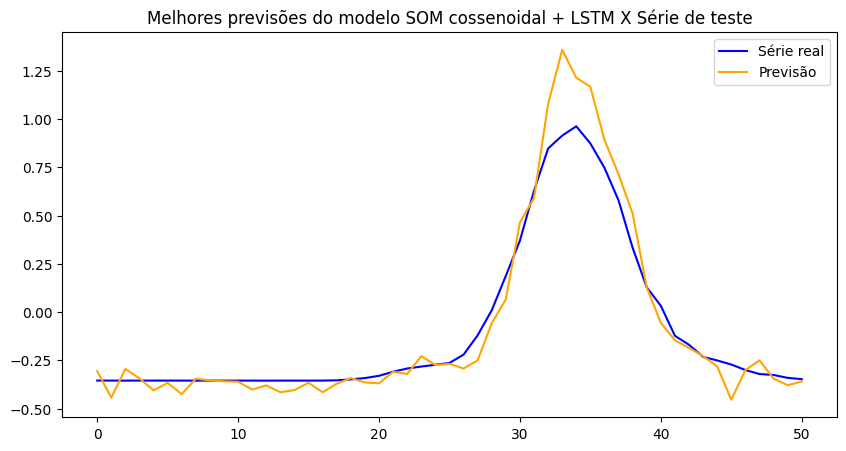

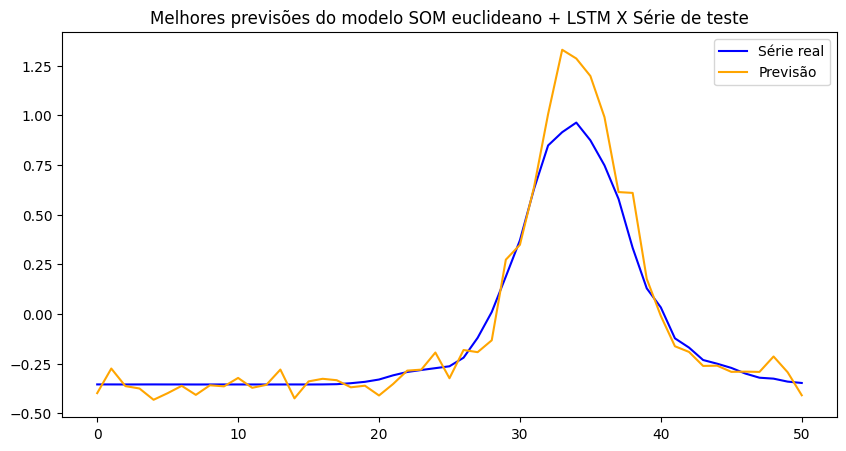

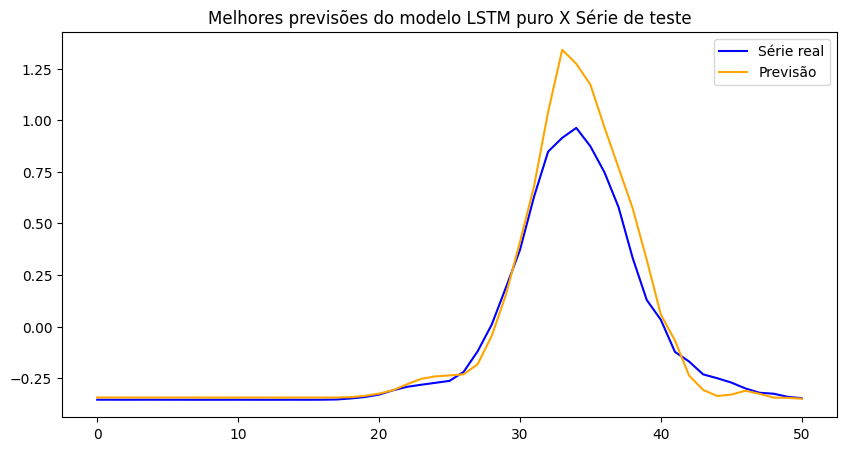

In [ ]:
insect_1 = dataset_dict['InsectWingbeatSound']['X'][samples_insect[0]].copy().flatten()
insect_1_results, insect_1_graph1, insect_1_graph2, insect_1_graph3 = pipeline_TS_SOM_LSTM(insect_1, epochs_SOM=200, max_iter=270,
                                                                                           repeats_LSTM=1, epochs_LSTM=150)
insect_1_results

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Otimização encontrada! Silhueta: 0.43655133472832974

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 3 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Otimização encontrada! Silhueta: 0.459304775386146

Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.1
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 5 / Dimensão n: 1 / Taxa de aprendizagem: 0.05
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem: 0.5
Testando os seguintes valores: Tamanho de janela: 5 / Dimensão m: 7 / Dimensão n: 1 / Taxa de aprendizagem: 

1/1 [==============================] - 1s 1s/step
Epoch 1/150
7/7 [==============================] - 2s 5ms/step - loss: 0.9433
Epoch 2/150
7/7 [==============================] - 0s 5ms/step - loss: 0.8207
Epoch 3/150
7/7 [==============================] - 0s 6ms/step - loss: 0.7142
Epoch 4/150
7/7 [==============================] - 0s 6ms/step - loss: 0.6048
Epoch 5/150
7/7 [==============================] - 0s 4ms/step - loss: 0.4896
Epoch 6/150
7/7 [==============================] - 0s 4ms/step - loss: 0.3719
Epoch 7/150
7/7 [==============================] - 0s 5ms/step - loss: 0.2634
Epoch 8/150
7/7 [==============================] - 0s 5ms/step - loss: 0.1808
Epoch 9/150
7/7 [==============================] - 0s 4ms/step - loss: 0.1623
Epoch 10/150
7/7 [==============================] - 0s 5ms/step - loss: 0.1417
Epoch 11/150
7/7 [==============================] - 0s 5ms/step - loss: 0.1258
Epoch 12/150
7/7 [==============================] - 0s 5ms/step - loss: 0.1225
Epoch 13/15

Streaming output truncated to the last 5000 lines.
Epoch 60/150
7/7 [==============================] - 0s 10ms/step - loss: 0.0302
Epoch 61/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0283
Epoch 62/150
7/7 [==============================] - 0s 7ms/step - loss: 0.0300
Epoch 63/150
7/7 [==============================] - 0s 6ms/step - loss: 0.0307
Epoch 64/150
7/7 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 65/150
7/7 [==============================] - 0s 12ms/step - loss: 0.0264
Epoch 66/150
7/7 [==============================] - 0s 10ms/step - loss: 0.0272
Epoch 67/150
7/7 [==============================] - 0s 12ms/step - loss: 0.0269
Epoch 68/150
7/7 [==============================] - 0s 11ms/step - loss: 0.0254
Epoch 69/150
7/7 [==============================] - 0s 7ms/step - loss: 0.0280
Epoch 70/150
7/7 [==============================] - 0s 6ms/step - loss: 0.0279
Epoch 71/150
7/7 [==============================] - 0s 6ms/step - loss: 0.0

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0          0.035904          0.037282   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [-0.711519, -0.74259603, -0.77568513, -0.81345...          0.037643   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          0.038029  [-0.7459222, -0.73831815, -0.75210476, -0.7987...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0        0.004738        0.003862   

                                 Previsoes_LSTM_puro  
0  [[-0.7619108], [-0.7737583], [-0.7719511], [-0...

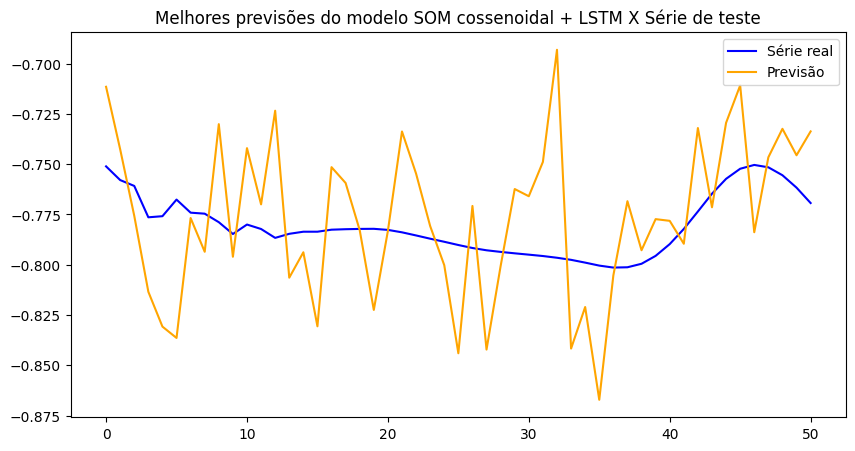

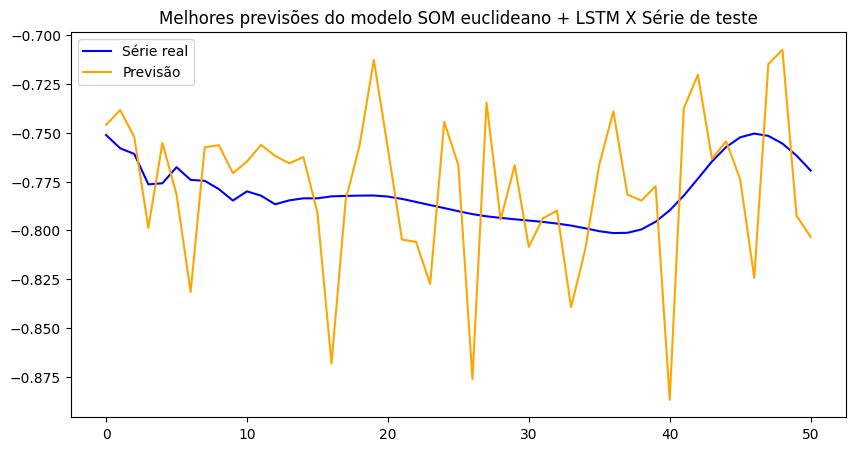

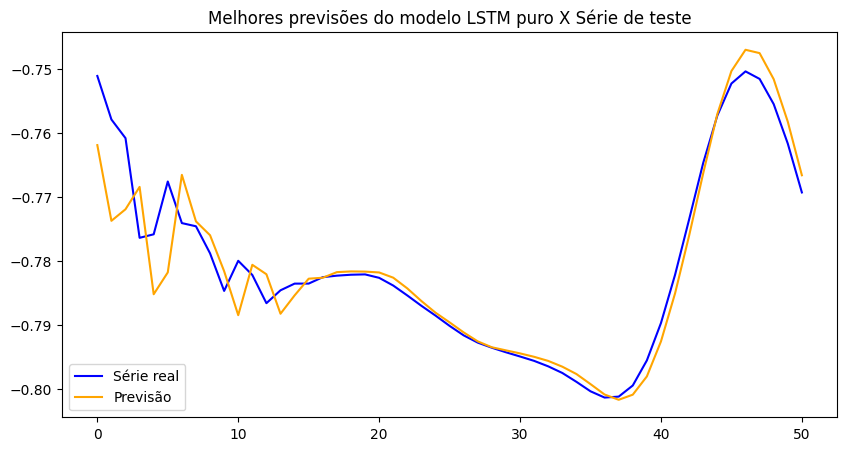

In [ ]:
insect_2 = dataset_dict['InsectWingbeatSound']['X'][samples_insect[1]].copy().flatten()
insect_2_results, insect_2_graph1, insect_2_graph2, insect_2_graph3 = pipeline_TS_SOM_LSTM(insect_2, epochs_SOM=200, max_iter=270,
                                                                                           repeats_LSTM=1, epochs_LSTM=150)
insect_2_results

## Dataset FaceAll

In [ ]:
# Identifying how many classes the dataset has and selecting two of them randomly
np.random.seed(42)
classes_face = np.unique(dataset_dict['FaceAll']['y'])
classes_face = np.random.choice(classes_face, 2).astype(int)

# Selecting two samples, each belonging to a different class of the dataset
samples_face = []
for class_face in classes_face:
  candidates = [index for index in range(len(dataset_dict['FaceAll']['y'])) if int(dataset_dict['FaceAll']['y'][index]) == class_face]
  samples_face.append(np.random.choice(candidatos, 1))
print(samples_face)

[array([684]), array([454])]


Streaming output truncated to the last 5000 lines.
Epoch 60/150
4/4 [==============================] - 0s 8ms/step - loss: 0.3662
Epoch 61/150
4/4 [==============================] - 0s 8ms/step - loss: 0.3650
Epoch 62/150
4/4 [==============================] - 0s 8ms/step - loss: 0.3582
Epoch 63/150
4/4 [==============================] - 0s 8ms/step - loss: 0.3466
Epoch 64/150
4/4 [==============================] - 0s 8ms/step - loss: 0.3468
Epoch 65/150
4/4 [==============================] - 0s 10ms/step - loss: 0.3436
Epoch 66/150
4/4 [==============================] - 0s 9ms/step - loss: 0.3425
Epoch 67/150
4/4 [==============================] - 0s 8ms/step - loss: 0.3445
Epoch 68/150
4/4 [==============================] - 0s 10ms/step - loss: 0.3415
Epoch 69/150
4/4 [==============================] - 0s 9ms/step - loss: 0.3417
Epoch 70/150
4/4 [==============================] - 0s 12ms/step - loss: 0.3429
Epoch 71/150
4/4 [==============================] - 0s 13ms/step - loss: 0.34

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0          0.420484          2.422333   
1          0.413386          1.086440   
2          0.425195          1.578486   
3          0.391336          0.750280   
4          0.398492          2.128134   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [1.0518438, 1.2047799, 0.07533811, 0.31252092,...          0.400449   
1  [0.9162166, 1.1919588, 0.030698746, 0.25643572...          0.377773   
2  [0.9822237, 1.368623, -0.004095141, 0.21962251...          0.383688   
3  [0.9307648, 1.2082536, 0.124797955, 0.09433138...          0.398122   
4  [0.92695487, 0.9682144, -0.1734068, 0.3666115,...          0.401705   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          4.705116  [0.93592054, 1.1547632, 0.14360225, 0.20019566...   
1          2.104157  [1.0104967, 1.02511, 0.07168857, 0.23802118, -...   
2          3.120511  [0.887082, 1.1475929, 0.10180588, 0.36663443, ...   
3          4.923889  [1.0007741, 1.1916316, -0.015156411, 0.3474945...   
4          3.406874  [0.854006, 1.1183504, 0.048604302, 0.39185455,...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0        0.420759        5.061736   
1        0.400478        2.589404   
2        0.400874        2.846656   
3        0.404040        5.391466   
4        0.406667        1.386312   

                                 Previsoes_LSTM_puro  
0  [[0.85200095], [1.0856185], [-0.14824079], [0....  
1  [[1.0154295], [1.2071518], [-0.12173988], [0.1...  
2  [[0.87849987], [1.1679233], [0.038075943], [0....  
3  [[0.9069175], [1.1087049], [-0.04867724], [0.0...  
4  [[1.0094894], [1.252547], [0.03371814], [0.247...

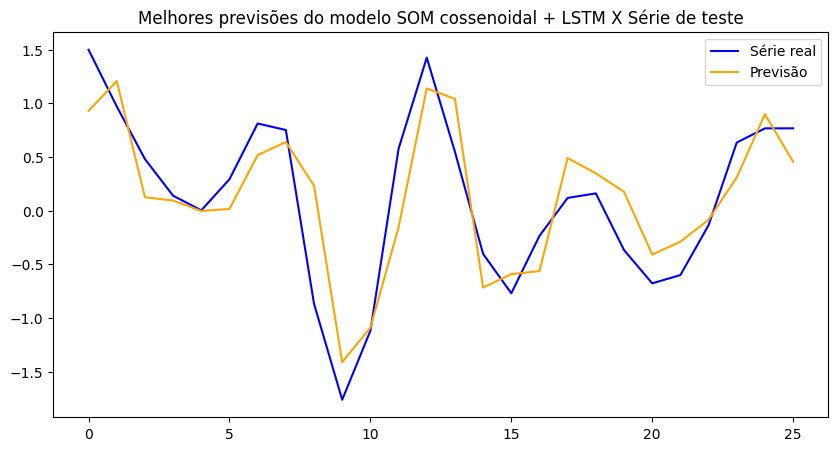

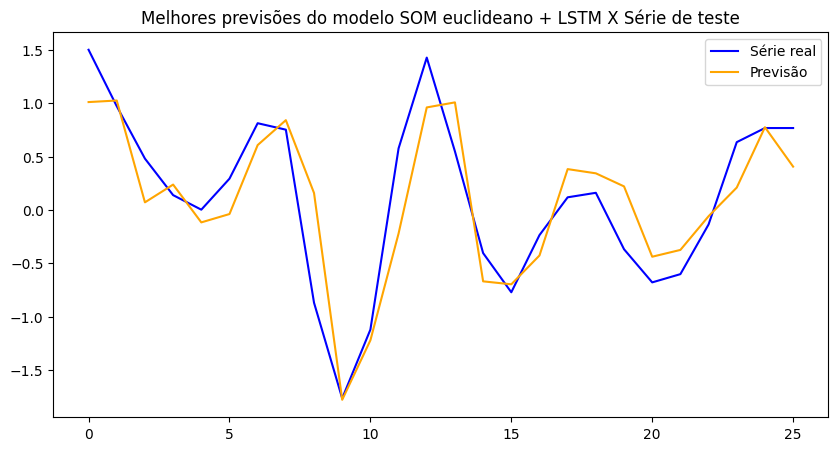

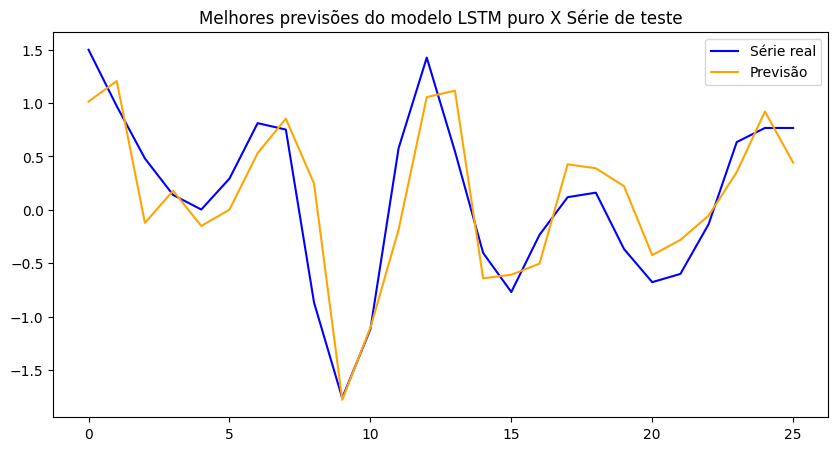

In [ ]:
face_1 = dataset_dict['FaceAll']['X'][samples_face[0]].copy().flatten()
face_1_results, face_1_graph1, face_1_graph2, face_1_graph3 = pipeline_TS_SOM_LSTM(face_1, epochs_SOM=200, max_iter=270,
                                                                                   repeats_LSTM=1, epochs_LSTM=150)
face_1_results

Streaming output truncated to the last 5000 lines.
Epoch 60/150
4/4 [==============================] - 0s 16ms/step - loss: 0.1174
Epoch 61/150
4/4 [==============================] - 0s 13ms/step - loss: 0.1169
Epoch 62/150
4/4 [==============================] - 0s 11ms/step - loss: 0.1124
Epoch 63/150
4/4 [==============================] - 0s 14ms/step - loss: 0.1075
Epoch 64/150
4/4 [==============================] - 0s 11ms/step - loss: 0.1059
Epoch 65/150
4/4 [==============================] - 0s 12ms/step - loss: 0.1025
Epoch 66/150
4/4 [==============================] - 0s 15ms/step - loss: 0.1017
Epoch 67/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0987
Epoch 68/150
4/4 [==============================] - 0s 9ms/step - loss: 0.1048
Epoch 69/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0953
Epoch 70/150
4/4 [==============================] - 0s 11ms/step - loss: 0.1035
Epoch 71/150
4/4 [==============================] - 0s 15ms/step - loss

RMSE_SOMcos_LSTM  MAPE_SOMcos_LSTM  \
0          0.121147          1.744289   
1          0.135494          2.979315   
2          0.123652          2.561657   
3          0.135093          1.514385   
4          0.123970          1.231517   

                               Previsoes_SOMcos_LSTM  RMSE_SOMeuc_LSTM  \
0  [0.20013045, 0.04680646, -0.04029835, -0.00964...          0.127578   
1  [0.15041961, 0.06327404, 0.016671607, -0.01482...          0.123702   
2  [0.19387779, 0.06303531, -0.0035673399, -0.054...          0.150331   
3  [0.25741455, -0.0035701813, 0.06254473, -0.014...          0.122091   
4  [0.1929214, 0.016608182, 0.015899375, 0.029183...          0.126838   

   MAPE_SOMeuc_LSTM                              Previsoes_SOMeuc_LSTM  \
0          1.538036  [0.1474423, 0.060687143, 0.034309983, -0.06152...   
1          2.306470  [0.25547388, 0.048693627, -0.036412887, -0.038...   
2          1.172609  [0.24495466, -0.03750801, -0.04447022, 0.04098...   
3          2.972599  [0.23143001, 0.0059065856, 0.028315574, 0.0145...   
4          2.292749  [0.16913141, -0.008929182, 0.073605955, 0.0056...   

   RMSE_LSTM_puro  MAPE_LSTM_puro  \
0        0.127548        2.312219   
1        0.129454        1.503801   
2        0.131235        1.626299   
3        0.127408        1.880998   
4        0.126073        1.888570   

                                 Previsoes_LSTM_puro  
0  [[0.19660197], [0.0066678915], [-0.015294632],...  
1  [[0.19562571], [0.009658435], [-0.009577533], ...  
2  [[0.20701514], [0.014040609], [-0.007106006], ...  
3  [[0.2191188], [0.019232295], [-0.001179345], [...  
4  [[0.19652691], [0.0076950793], [-0.013891727],...

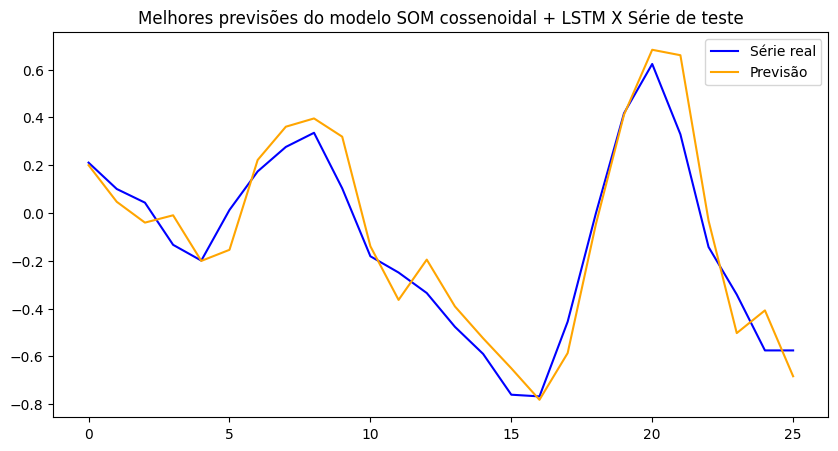

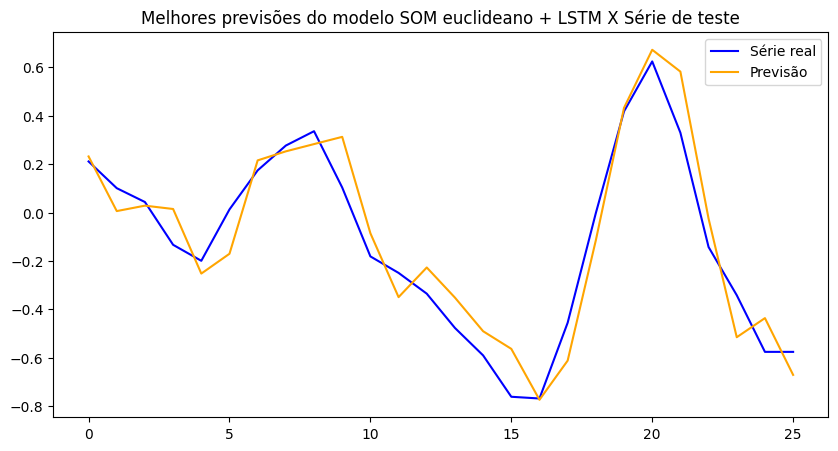

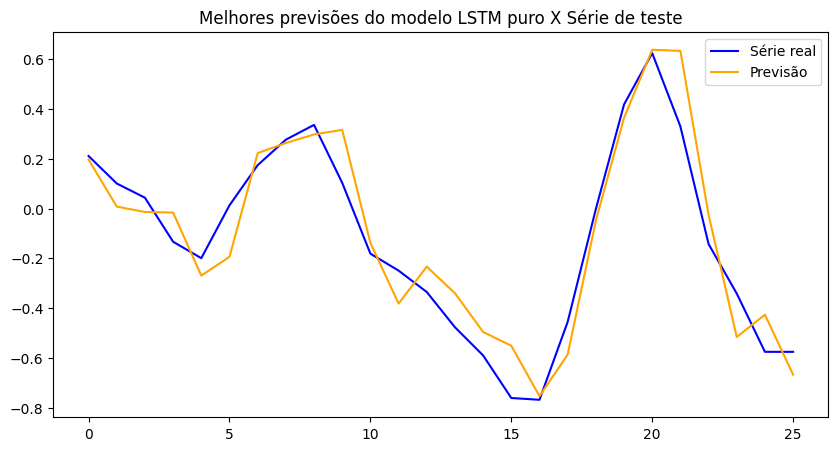

In [ ]:
face_2 = dataset_dict['FaceAll']['X'][samples_face[1]].copy().flatten()
face_2_results, face_2_graph1, face_2_graph2, face_2_graph3 = pipeline_TS_SOM_LSTM(face_2, epochs_SOM=200, max_iter=270,
                                                                                   repeats_LSTM=1, epochs_LSTM=150)
face_2_results

# Summarizing results

In [ ]:
print('Results of Adiac dataset')
print('\nSOM cosine + LSTM')
print(f'Mean RMSE of sample 1: {round(adiac_1_results.RMSE_SOMcos_LSTM.mean(),4)} (standard deviation {round(adiac_1_results.RMSE_SOMcos_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(adiac_2_results.MAPE_SOMcos_LSTM.mean(),4)} (standard deviation {round(adiac_2_results.MAPE_SOMcos_LSTM.std(),4)})')
print('\nSOM euclidean + LSTM')
print(f'Mean RMSE of sample 1: {round(adiac_1_results.RMSE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(adiac_1_results.RMSE_SOMeuc_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(adiac_2_results.MAPE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(adiac_2_results.MAPE_SOMeuc_LSTM.std(),4)})')
print('\nLSTM raw')
print(f'Mean RMSE of sample 1: {round(adiac_1_results.RMSE_LSTM_raw.mean(),4)} (standard deviation {round(adiac_1_results.RMSE_LSTM_raw.std(),4)})')
print(f'Mean MAPE of sample 2: {round(adiac_2_results.MAPE_LSTM_raw.mean(),4)} (standard deviation {round(adiac_2_results.MAPE_LSTM_raw.std(),4)})')

In [ ]:
print('Results of ECG5000 dataset')
print('\nSOM cosine + LSTM')
print(f'Mean RMSE of sample 1: {round(ecg_1_results.RMSE_SOMcos_LSTM.mean(),4)} (standard deviation {round(ecg_1_results.RMSE_SOMcos_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(ecg_2_results.MAPE_SOMcos_LSTM.mean(),4)} (standard deviation {round(ecg_2_results.MAPE_SOMcos_LSTM.std(),4)})')
print('\nSOM euclidean + LSTM')
print(f'Mean RMSE of sample 1: {round(ecg_1_results.RMSE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(ecg_1_results.RMSE_SOMeuc_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(ecg_2_results.MAPE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(ecg_2_results.MAPE_SOMeuc_LSTM.std(),4)})')
print('\nLSTM raw')
print(f'Mean RMSE of sample 1: {round(ecg_1_results.RMSE_LSTM_raw.mean(),4)} (standard deviation {round(ecg_1_results.RMSE_LSTM_raw.std(),4)})')
print(f'Mean MAPE of sample 2: {round(ecg_2_results.MAPE_LSTM_raw.mean(),4)} (standard deviation {round(ecg_2_results.MAPE_LSTM_raw.std(),4)})')

In [ ]:
print('Results of InsectWingbeatSound dataset')
print('\nSOM cosine + LSTM')
print(f'Mean RMSE of sample 1: {round(insect_1_results.RMSE_SOMcos_LSTM.mean(),4)} (standard deviation {round(insect_1_results.RMSE_SOMcos_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(insect_2_results.MAPE_SOMcos_LSTM.mean(),4)} (standard deviation {round(insect_2_results.MAPE_SOMcos_LSTM.std(),4)})')
print('\nSOM euclidean + LSTM')
print(f'Mean RMSE of sample 1: {round(insect_1_results.RMSE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(insect_1_results.RMSE_SOMeuc_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(insect_2_results.MAPE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(insect_2_results.MAPE_SOMeuc_LSTM.std(),4)})')
print('\nLSTM raw')
print(f'Mean RMSE of sample 1: {round(insect_1_results.RMSE_LSTM_raw.mean(),4)} (standard deviation {round(insect_1_results.RMSE_LSTM_raw.std(),4)})')
print(f'Mean MAPE of sample 2: {round(insect_2_results.MAPE_LSTM_raw.mean(),4)} (standard deviation {round(insect_2_results.MAPE_LSTM_raw.std(),4)})')

In [ ]:
print('Results of FaceAll dataset')
print('\nSOM cosine + LSTM')
print(f'Mean RMSE of sample 1: {round(face_1_results.RMSE_SOMcos_LSTM.mean(),4)} (standard deviation {round(face_1_results.RMSE_SOMcos_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(face_2_results.MAPE_SOMcos_LSTM.mean(),4)} (standard deviation {round(face_2_results.MAPE_SOMcos_LSTM.std(),4)})')
print('\nSOM euclidean + LSTM')
print(f'Mean RMSE of sample 1: {round(face_1_results.RMSE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(face_1_results.RMSE_SOMeuc_LSTM.std(),4)})')
print(f'Mean MAPE of sample 2: {round(face_2_results.MAPE_SOMeuc_LSTM.mean(),4)} (standard deviation {round(face_2_results.MAPE_SOMeuc_LSTM.std(),4)})')
print('\nLSTM raw')
print(f'Mean RMSE of sample 1: {round(face_1_results.RMSE_LSTM_raw.mean(),4)} (standard deviation {round(face_1_results.RMSE_LSTM_raw.std(),4)})')
print(f'Mean MAPE of sample 2: {round(face_2_results.MAPE_LSTM_raw.mean(),4)} (standard deviation {round(face_2_results.MAPE_LSTM_raw.std(),4)})')

# Statistical tests

## Adiac

In [ ]:
RMSE_adiac_1 = [adiac_1_results.RMSE_SOMcos_LSTM, adiac_1_results.RMSE_SOMeuc_LSTM, adiac_1_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(adiac_1_results.RMSE_SOMcos_LSTM,
                                                 adiac_1_results.RMSE_SOMeuc_LSTM,
                                                 adiac_1_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_adiac_1)
print('Friedman testing RMSE of sample 1')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_adiac_1 = [adiac_1_results.MAPE_SOMcos_LSTM, adiac_1_results.MAPE_SOMeuc_LSTM, adiac_1_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(adiac_1_results.MAPE_SOMcos_LSTM,
                                                 adiac_1_results.MAPE_SOMeuc_LSTM,
                                                 adiac_1_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_adiac_1)
print('Friedman testing MAPE of sample 1')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}\n\n\n')

RMSE_adiac_2 = [adiac_2_results.RMSE_SOMcos_LSTM, adiac_2_results.RMSE_SOMeuc_LSTM, adiac_2_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(adiac_2_results.RMSE_SOMcos_LSTM,
                                                 adiac_2_results.RMSE_SOMeuc_LSTM,
                                                 adiac_2_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_adiac_2)
print('Friedman testing RMSE of sample 2')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_adiac_2 = [adiac_2_results.MAPE_SOMcos_LSTM, adiac_2_results.MAPE_SOMeuc_LSTM, adiac_2_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(adiac_2_results.MAPE_SOMcos_LSTM,
                                                 adiac_2_results.MAPE_SOMeuc_LSTM,
                                                 adiac_2_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_adiac_2)
print('Friedman testing MAPE of sample 2')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}')

## ECG5000

In [ ]:
RMSE_ecg_1 = [ecg_1_results.RMSE_SOMcos_LSTM, ecg_1_results.RMSE_SOMeuc_LSTM, ecg_1_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(ecg_1_results.RMSE_SOMcos_LSTM,
                                                 ecg_1_results.RMSE_SOMeuc_LSTM,
                                                 ecg_1_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_ecg_1)
print('Friedman testing RMSE of sample 1')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_ecg_1 = [ecg_1_results.MAPE_SOMcos_LSTM, ecg_1_results.MAPE_SOMeuc_LSTM, ecg_1_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(ecg_1_results.MAPE_SOMcos_LSTM,
                                                 ecg_1_results.MAPE_SOMeuc_LSTM,
                                                 ecg_1_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_ecg_1)
print('Friedman testing MAPE of sample 1')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}\n\n\n')

RMSE_ecg_2 = [ecg_2_results.RMSE_SOMcos_LSTM, ecg_2_results.RMSE_SOMeuc_LSTM, ecg_2_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(ecg_2_results.RMSE_SOMcos_LSTM,
                                                 ecg_2_results.RMSE_SOMeuc_LSTM,
                                                 ecg_2_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_ecg_2)
print('Friedman testing RMSE of sample 2')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_ecg_2 = [ecg_2_results.MAPE_SOMcos_LSTM, ecg_2_results.MAPE_SOMeuc_LSTM, ecg_2_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(ecg_2_results.MAPE_SOMcos_LSTM,
                                                 ecg_2_results.MAPE_SOMeuc_LSTM,
                                                 ecg_2_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_ecg_2)
print('Friedman testing MAPE of sample 2')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}')

## InsectWingbeatSound

In [ ]:
RMSE_insect_1 = [insect_1_results.RMSE_SOMcos_LSTM, insect_1_results.RMSE_SOMeuc_LSTM, insect_1_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(insect_1_results.RMSE_SOMcos_LSTM,
                                                 insect_1_results.RMSE_SOMeuc_LSTM,
                                                 insect_1_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_insect_1)
print('Friedman testing RMSE of sample 1')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_insect_1 = [insect_1_results.MAPE_SOMcos_LSTM, insect_1_results.MAPE_SOMeuc_LSTM, insect_1_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(insect_1_results.MAPE_SOMcos_LSTM,
                                                 insect_1_results.MAPE_SOMeuc_LSTM,
                                                 insect_1_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_insect_1)
print('Friedman testing MAPE of sample 1')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}\n\n\n')

RMSE_insect_2 = [insect_2_results.RMSE_SOMcos_LSTM, insect_2_results.RMSE_SOMeuc_LSTM, insect_2_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(insect_2_results.RMSE_SOMcos_LSTM,
                                                 insect_2_results.RMSE_SOMeuc_LSTM,
                                                 insect_2_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_insect_2)
print('Friedman testing RMSE of sample 2')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_insect_2 = [insect_2_results.MAPE_SOMcos_LSTM, insect_2_results.MAPE_SOMeuc_LSTM, insect_2_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(insect_2_results.MAPE_SOMcos_LSTM,
                                                  insect_2_results.MAPE_SOMeuc_LSTM,
                                                  insect_2_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_insect_2)
print('Friedman testing MAPE of sample 2')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}')

## FaceAll

In [ ]:
RMSE_face_1 = [face_1_results.RMSE_SOMcos_LSTM, face_1_results.RMSE_SOMeuc_LSTM, face_1_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(face_1_results.RMSE_SOMcos_LSTM,
                                                 face_1_results.RMSE_SOMeuc_LSTM,
                                                 face_1_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_face_1)
print('Friedman testing RMSE of sample 1')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_face_1 = [face_1_results.MAPE_SOMcos_LSTM, face_1_results.MAPE_SOMeuc_LSTM, face_1_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(face_1_results.MAPE_SOMcos_LSTM,
                                                 face_1_results.MAPE_SOMeuc_LSTM,
                                                 face_1_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_face_1)
print('Friedman testing MAPE of sample 1')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}\n\n\n')

RMSE_face_2 = [face_2_results.RMSE_SOMcos_LSTM, face_2_results.RMSE_SOMeuc_LSTM, face_2_results.RMSE_LSTM_raw]
RMSE_test, RMSE_pvalue = stats.friedmanchisquare(face_2_results.RMSE_SOMcos_LSTM,
                                                 face_2_results.RMSE_SOMeuc_LSTM,
                                                 face_2_results.RMSE_LSTM_raw)
RMSE_nemenyi = sp.posthoc_nemenyi(RMSE_face_2)
print('Friedman testing RMSE of sample 2')
print(f'Friedman statistic: {round(RMSE_test,4)}')
print(f'P-value: {RMSE_pvalue}')
print('\nNemenyi test of RMSE')
print(f'Nemenyi statistic:\n{RMSE_nemenyi}\n\n\n')

MAPE_face_2 = [face_2_results.MAPE_SOMcos_LSTM, face_2_results.MAPE_SOMeuc_LSTM, face_2_results.MAPE_LSTM_raw]
MAPE_test, MAPE_pvalue = stats.friedmanchisquare(face_2_results.MAPE_SOMcos_LSTM,
                                                 face_2_results.MAPE_SOMeuc_LSTM,
                                                 face_2_results.MAPE_LSTM_raw)
MAPE_nemenyi = sp.posthoc_nemenyi(MAPE_face_2)
print('Friedman testing MAPE of sample 2')
print(f'Friedman statistic: {round(MAPE_test,4)}')
print(f'P-value: {MAPE_pvalue}')
print('\nNemenyi test of MAPE')
print(f'Nemenyi statistic:\n{MAPE_nemenyi}')